In [1]:
%load_ext line_profiler
%load_ext memory_profiler

%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import util
import models

from os.path import expanduser
from os import path
import logging

logging.basicConfig(level=logging.DEBUG)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn_evaluation import plot as sk_plot

import yass
from yass import read_config, preprocess, detect
from yass.augment import make_training_data, make
from yass.neuralnetwork import NeuralNetDetector, NeuralNetTriage, AutoEncoder 
from yass.explore import RecordingExplorer, SpikeTrainExplorer

import numpy as np
from scipy.io import loadmat

from dstools import plot

Using TensorFlow backend.
DEBUG:yass:Tensorflow GPU configuration detected


In [4]:
yass.set_config("../config/49-lab.yaml")
CONFIG = read_config()

DEBUG:yass.config.config:Loaded from file: ../config/49-lab.yaml
DEBUG:yass:CONFIG set to: {'data': {'root_folder': '/home/Edu/data', 'recordings': 'ej49_data1_set1.bin', 'geometry': 'ej49_geometry1.txt'}, 'resources': {'max_memory': '500MB', 'max_memory_gpu': '1MB', 'processes': 'max'}, 'recordings': {'dtype': 'int16', 'sampling_rate': 20000, 'n_channels': 49, 'spatial_radius': 70, 'spike_size_ms': 1, 'order': 'samples'}, 'preprocess': {'apply_filter': True, 'dtype': 'float32', 'if_file_exists': 'skip', 'filter': {'order': 3, 'low_pass_freq': 300, 'high_factor': 0.1}}, 'detect': {'method': 'nn', 'temporal_features': 3, 'save_results': False, 'if_file_exists': 'skip', 'neural_network_detector': {'filename': '/home/Edu/dev/yass/src/yass/assets/models/detect_nn1.ckpt', 'threshold_spike': 0.5}, 'neural_network_triage': {'filename': '/home/Edu/dev/yass/src/yass/assets/models/triage_nn1.ckpt', 'threshold_collision': 0.5}, 'neural_network_autoencoder': {'filename': '/home/Edu/dev/yass/src/ya

In [5]:
path_to_data = path.expanduser('~/data')
path_to_ground_truth = path.join(path_to_data,
                                 'groundtruth_ej49_data1_set1.mat')
path_to_standarized = path.join(path_to_data, 'tmp', 'preprocess',
                               'standarized.bin')
path_to_geom = path.join(path_to_data, 'ej49_geometry1.txt')

path_to_here = path.expanduser('~/dev/private-yass/nnet')

In [6]:
# load ground truth
_ = loadmat(path_to_ground_truth)
gt = np.hstack([_['spt_gt'], _['L_gt']])

gt = gt[2:-1]
gt[:, 1] = gt[:, 1] - 1

# compensate alignment
gt[:, 0] = gt[:, 0] + 5

In [7]:
# explorer for standarized data
re = RecordingExplorer(path_to_standarized,
                       path_to_geom=path_to_geom,
                       n_channels=49,
                       spike_size=10,
                       neighbor_radius=70,
                       dtype='float32',
                       data_order='samples')

# compute templates for ground truth
se = SpikeTrainExplorer(gt, re)

DEBUG:yass.explore.explorers:Loaded 49 waveforms
DEBUG:yass.explore.explorers:Finished computing templates, shape is: (21, 49, 49)


## Inspecting ground truth amplitudes and templates

In [8]:
def spike_amplitudes_from_spikes(spikes):
    abs_value = np.abs(spikes)
    
    amplitudes = np.max(abs_value, axis=(1, 2))
    main_channels = np.argmax(np.max(abs_value, axis=1), axis=1)

    return amplitudes, main_channels

DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/home/Edu/miniconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/home/Edu/miniconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


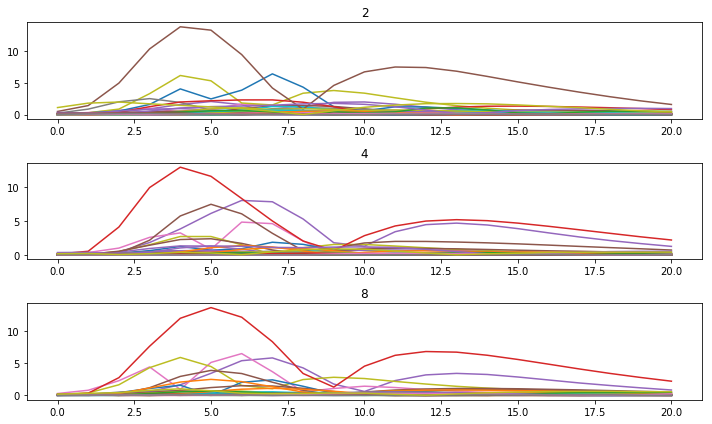

In [9]:
plt.rcParams['figure.figsize'] = (10, 6)
plot.grid_from_array(np.abs(se.templates), axis=0, elements=[2, 4, 8])

In [10]:
templates = np.copy(se.templates)
templates = np.concatenate((templates, np.zeros((49, 21, 1))), axis=2)

In [11]:
amps, main_channels = spike_amplitudes_from_spikes(se.templates)

In [12]:
print(amps[2], main_channels[2])

13.871453 25


/home/Edu/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


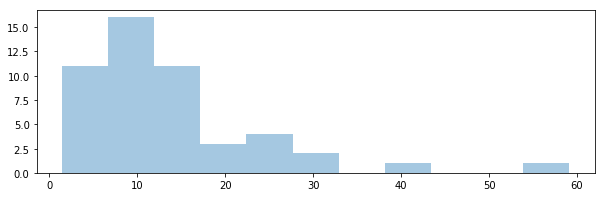

In [13]:
plt.rcParams['figure.figsize'] = (10, 3)
_ = sns.distplot(amps, kde=False)

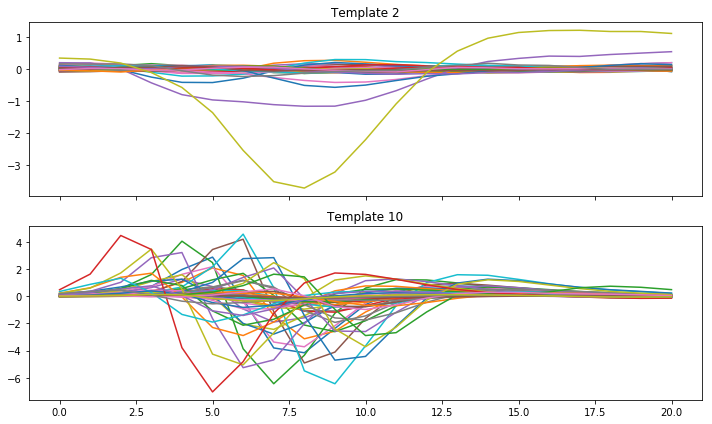

In [14]:
# this looks wrong
plt.rcParams['figure.figsize'] = (10, 6)
se.plot_templates(group_ids=[2, 10])

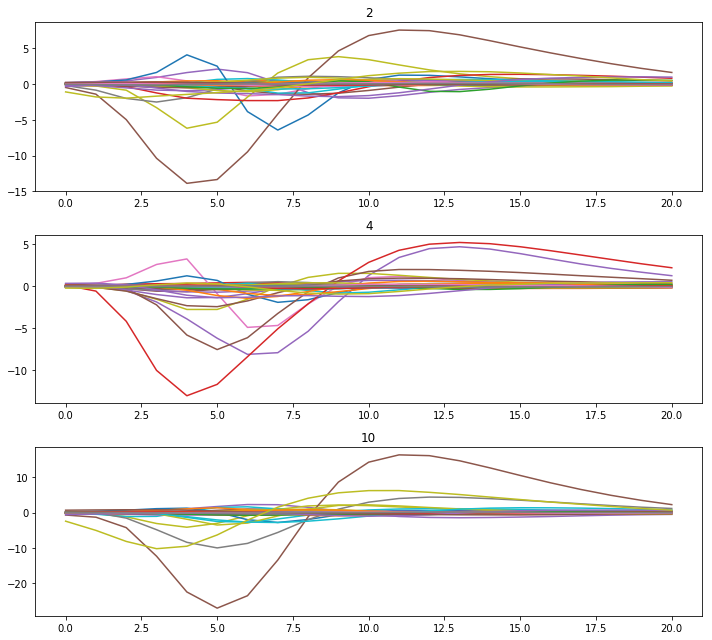

In [15]:
plt.rcParams['figure.figsize'] = (10, 9)
plot.grid_from_array(se.templates, axis=0, elements=[2, 4, 10])

In [16]:
from yass.geometry import make_channel_index

In [17]:
ch_index = make_channel_index(re.neigh_matrix, re.geom)

In [18]:
n_templates, waveform_length, n_channels = templates.shape

small_templates = np.empty((n_templates, waveform_length, 7))

for i in range(n_templates):
    main_channel = main_channels[i]
    neighbors = ch_index[main_channel]
    small_templates[i] = templates[i][:, neighbors]

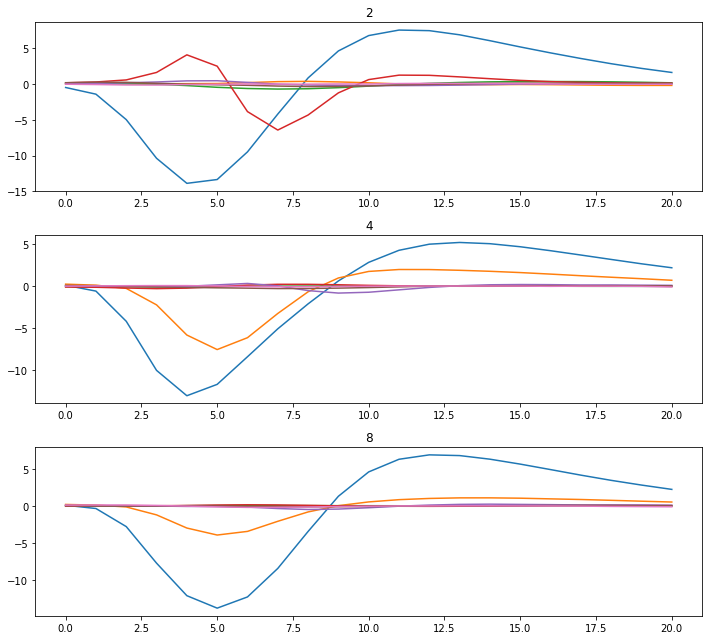

In [19]:
plt.rcParams['figure.figsize'] = (10, 9)
plot.grid_from_array(small_templates, axis=0, elements=[2, 4, 8])

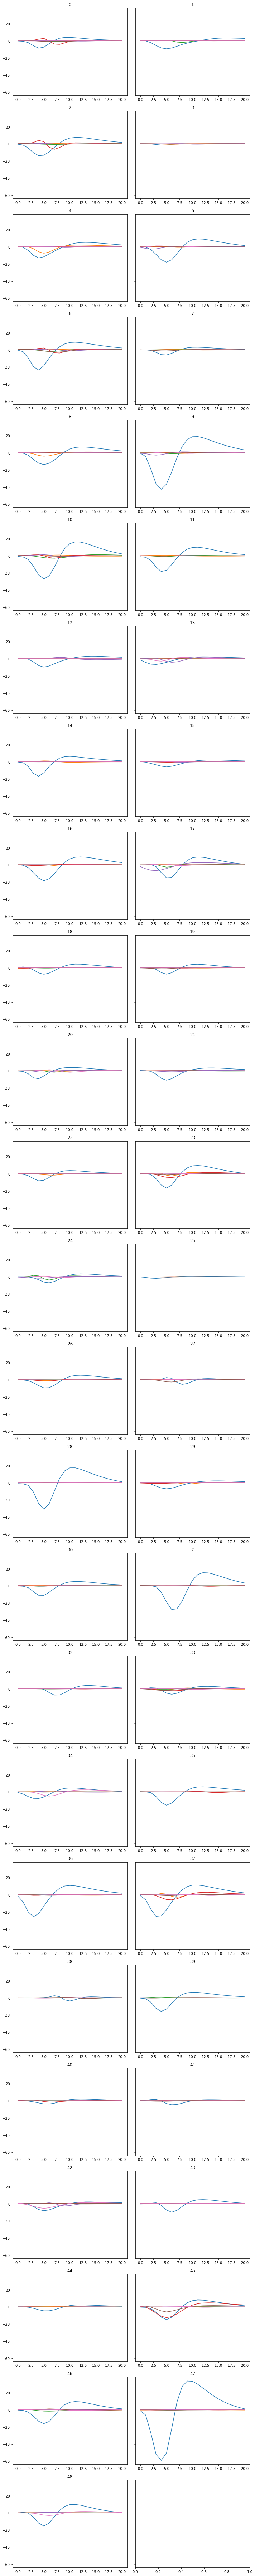

In [20]:
plt.rcParams['figure.figsize'] = (10, 100)
plot.grid_from_array(small_templates, axis=0, max_cols=2, sharey=True)

## Generating training data

In [21]:
# n_spikes = 50000
n_spikes = 10000

min_amplitude = 5
n_templates = np.max(gt[:,1]) + 1
chosen_templates = np.arange(n_templates)

In [22]:
(x_detect, y_detect,
 x_triage, y_triage,
 x_ae, y_ae) = make_training_data(CONFIG, gt, chosen_templates,
                                  min_amplitude, n_spikes,
                                  data_folder='/home/Edu/data/nnet/',
                                  multi_channel=True)

INFO:yass.augment.make:Getting templates...
INFO:yass.templates.util:Computing templates...
DEBUG:yass.batch.generator:Max memory: 500 MB. Itemsize: 4 bytes
INFO:yass.batch.batch:Applying function yass.templates.util.compute_weighted_templates...
  0%|          | 0/3 [00:00<?, ?it/s]DEBUG:yass.batch.generator:Observations per channel: 6,000,000. Number of channels: 49. Total observations: 294,000,000 Size to traverse: 1.1 GB
DEBUG:yass.batch.generator:Max observations per batch: 131,071,962 (500 MB), 2,674,938 max observations per channel
DEBUG:yass.batch.generator:Number of batches: 3
DEBUG:yass.batch.generator:Last batch with 31,856,076 observations (127424304), 650,124 observations per channel
DEBUG:yass.batch.util:Processing batch 0...
DEBUG:yass.batch.util:Applying function in batch 0 with size (2675018, 49)
DEBUG:yass.batch.util:Done Applying function in batch 0...
 33%|███▎      | 1/3 [00:03<00:07,  3.82s/it]DEBUG:yass.batch.util:Processing batch 1...
DEBUG:yass.batch.util:Apply

In [23]:
print(f'Training set sizes:\n\tdetect:{x_detect.shape}\n\ttriage:{x_triage.shape}\n\tautoencoder:{x_ae.shape}')

Training set sizes:
	detect:(109265, 21, 7)
	triage:(16810, 21, 7)
	autoencoder:(82410, 21)


In [24]:
# compute amplitude for positive and negative samples in the detect training set
x_detect_positive = x_detect[y_detect == 1]
x_detect_negative = x_detect[y_detect == 0]

amps_positive = np.max(np.abs(x_detect_positive), axis=(1, 2))
amps_negative = np.max(np.abs(x_detect_negative), axis=(1, 2))

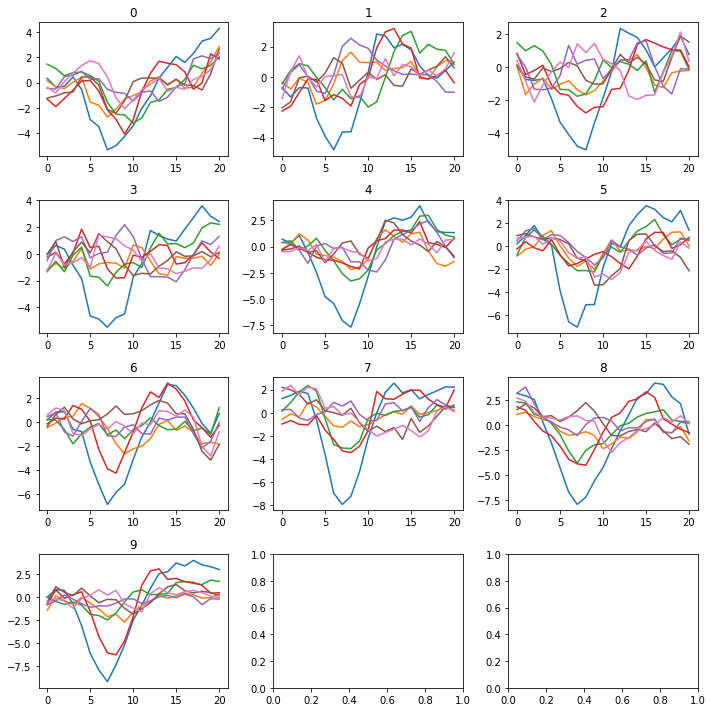

In [25]:
plt.rcParams['figure.figsize'] = (10, 10)
plot.grid_from_array(x_detect_positive, axis=0, elements=range(10))

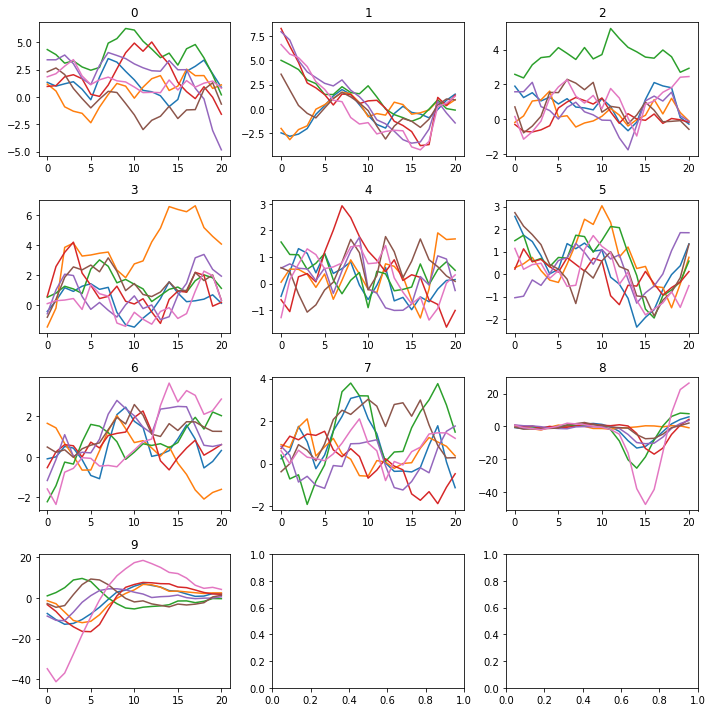

In [26]:
plt.rcParams['figure.figsize'] = (10, 10)
plot.grid_from_array(x_detect_negative, axis=0, elements=range(10))

/home/Edu/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


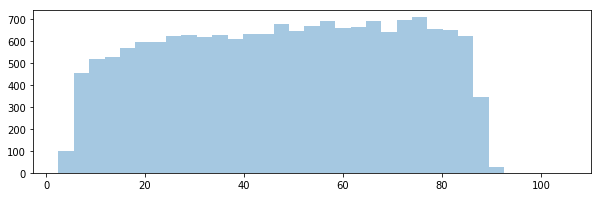

In [27]:
plt.rcParams['figure.figsize'] = (10, 3)
_ = sns.distplot(amps_positive, kde=False)

/home/Edu/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


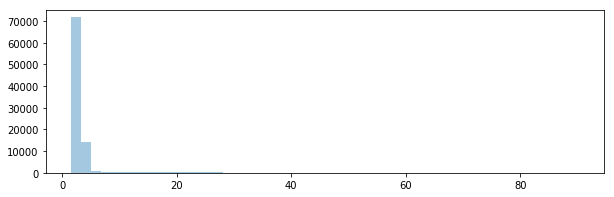

In [28]:
plt.rcParams['figure.figsize'] = (10, 3)
_ = sns.distplot(amps_negative, kde=False)

In [29]:
x_triage_positive = x_triage[y_triage == 1]
x_triage_negative = x_triage[y_triage == 0]

In [30]:
print(x_triage_positive.shape, x_triage_negative.shape)

(8405, 21, 7) (8405, 21, 7)


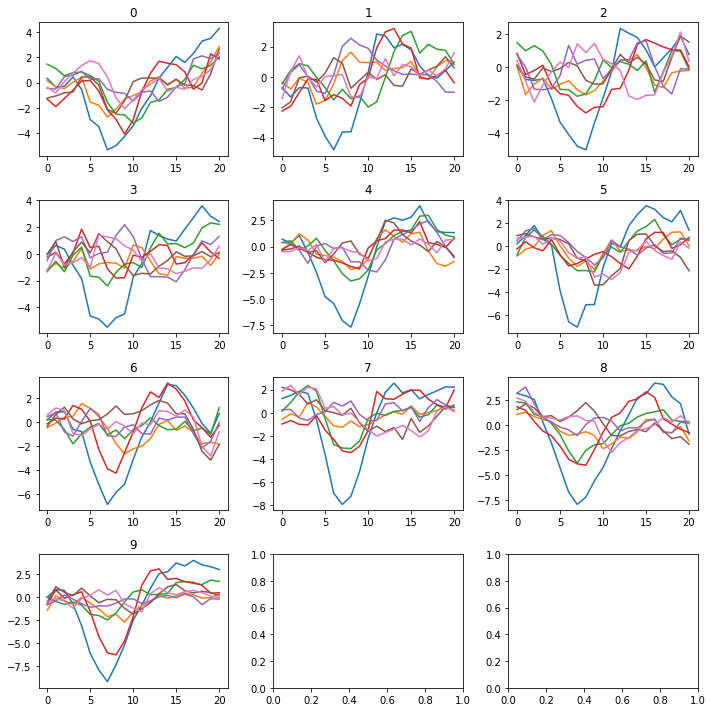

In [31]:
plt.rcParams['figure.figsize'] = (10, 10)
plot.grid_from_array(x_triage_positive, axis=0, elements=range(10))

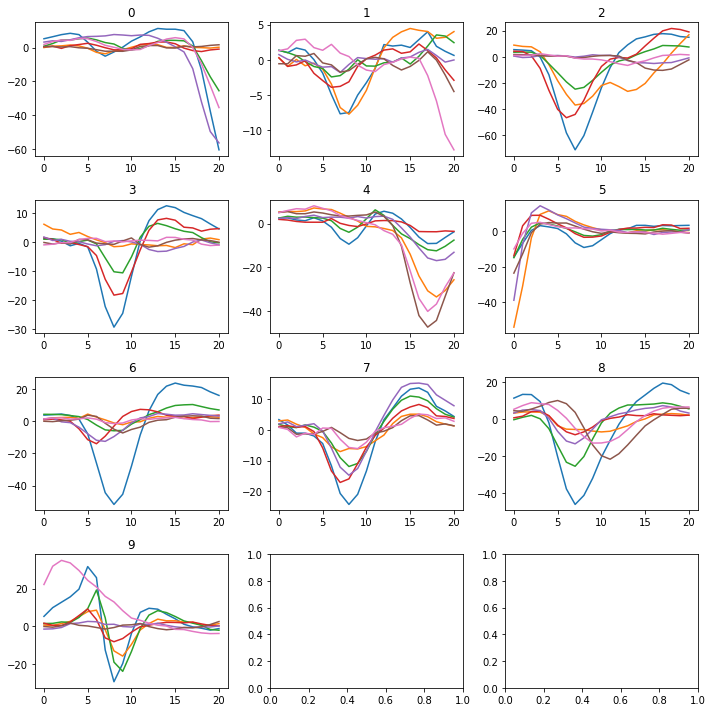

In [32]:
plt.rcParams['figure.figsize'] = (10, 10)
plot.grid_from_array(x_triage_negative, axis=0, elements=range(10))

# Training

In [33]:
n_iter = 5000

## Detector training

In [35]:
detect_name = path.join(path_to_here, 'models', 'detect-'+util.directory()+'.ckpt')
filters_detect = [8, 4]

_, waveform_length, n_neighbors =  x_detect.shape

detector = NeuralNetDetector(detect_name, filters_detect,
                             waveform_length, n_neighbors,
                             threshold=0.5,
                             channel_index=CONFIG.channel_index,
                             n_iter=n_iter)

detector.fit(x_detect, y_detect)

DEBUG:yass.neuralnetwork.model_detector:Training detector network...
Tr loss: 0.00063361845, Val loss: 0.005801572: 100%|██████████| 5000/5000 [00:24<00:00, 202.19it/s] 
DEBUG:yass.neuralnetwork.model_detector:Saving network: /home/Edu/dev/private-yass/nnet/models/detect-04-Jul-2018@15-56-13.ckpt
DEBUG:yass.neuralnetwork.model_detector:Saving network parameters: /home/Edu/dev/private-yass/nnet/models/detect-04-Jul-2018@15-56-13.yaml


## Triage training

In [36]:
triage_name = path.join(path_to_here, 'models', 'triage-'+util.directory()+'.ckpt')
filters_triage = [8, 4]

_, waveform_length, n_neighbors = x_triage.shape

triage = NeuralNetTriage(triage_name, filters_triage,
                         waveform_length=waveform_length,
                         threshold=0.5,
                         n_neighbors=n_neighbors,
                         n_iter=n_iter)

triage.fit(x_triage, y_triage)

DEBUG:yass.neuralnetwork.model_triage:Training triage network...
Tr loss: 0.1466712, Val loss: 0.19252071: 100%|██████████| 5000/5000 [00:20<00:00, 239.63it/s] 
DEBUG:yass.neuralnetwork.model_triage:Saving network: /home/Edu/dev/private-yass/nnet/models/triage-04-Jul-2018@15-56-47.ckpt
DEBUG:yass.neuralnetwork.model_triage:Saving network parameters: /home/Edu/dev/private-yass/nnet/models/triage-04-Jul-2018@15-56-47.yaml


# Evaluation

## Detect evaluation

In [38]:
y_pred = detector.predict(detector.x_test)
y_true = detector.y_test

print(metrics.classification_report(y_true, y_pred))

DEBUG:yass.neuralnetwork.model_detector:Restoring tensorflow session from: /home/Edu/dev/private-yass/nnet/models/detect-04-Jul-2018@15-56-13.ckpt


             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00     27708
        1.0       1.00      0.99      1.00      5072

avg / total       1.00      1.00      1.00     32780



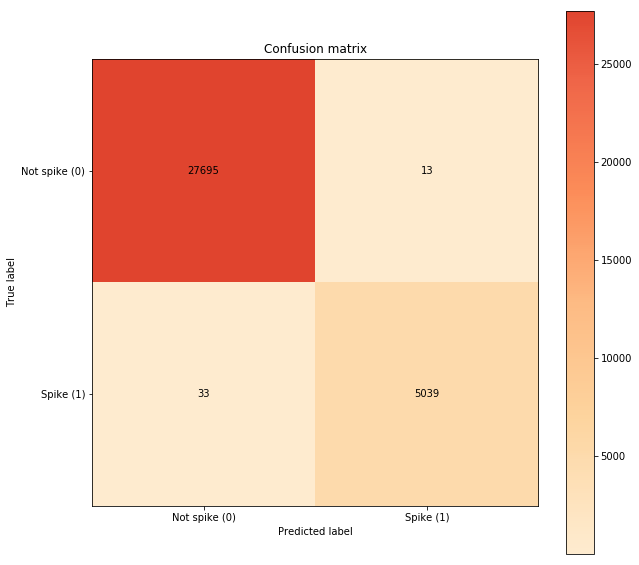

In [39]:
sk_plot.confusion_matrix(y_true, y_pred, target_names=['Not spike (0)', 'Spike (1)'])

In [40]:
fn_idx = np.logical_and(y_true == NeuralNetDetector.SPIKE, y_pred == NeuralNetDetector.NOT_SPIKE)
fp_idx = np.logical_and(y_true == NeuralNetDetector.NOT_SPIKE, y_pred == NeuralNetDetector.SPIKE)

fns = detector.x_test[fn_idx]
fps = detector.x_test[fp_idx]

fns_amps = np.max(np.abs(fns), axis=(1, 2))
fps_amps = np.max(np.abs(fps), axis=(1, 2))

/home/Edu/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


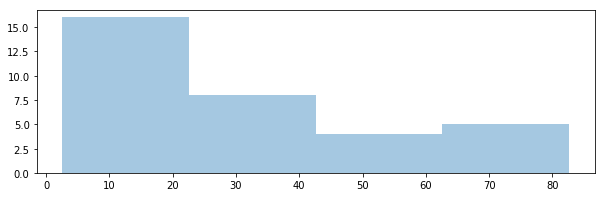

In [41]:
plt.rcParams['figure.figsize'] = (10, 3)
_ = sns.distplot(fns_amps, kde=False)

/home/Edu/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


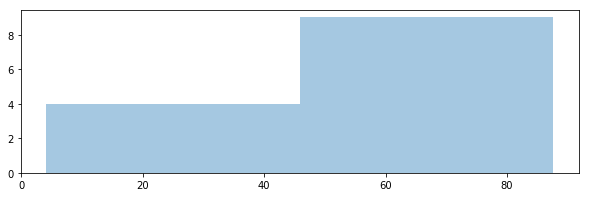

In [42]:
plt.rcParams['figure.figsize'] = (10, 3)
_ = sns.distplot(fps_amps, kde=False)

## Triage evaluation

In [43]:
y_pred = triage.predict(triage.x_test)
y_true = triage.y_test

print(metrics.classification_report(y_true, y_pred))

DEBUG:yass.neuralnetwork.model_triage:Restoring tensorflow session from: /home/Edu/dev/private-yass/nnet/models/triage-04-Jul-2018@15-56-47.ckpt


             precision    recall  f1-score   support

        0.0       0.98      0.88      0.93      2499
        1.0       0.90      0.98      0.94      2544

avg / total       0.94      0.93      0.93      5043



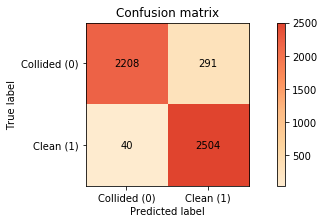

In [44]:
sk_plot.confusion_matrix(y_true, y_pred, target_names=['Collided (0)', 'Clean (1)'])

In [45]:
fn_idx = np.logical_and(y_true == NeuralNetTriage.CLEAN, y_pred == NeuralNetTriage.COLLIDED)
fp_idx = np.logical_and(y_true == NeuralNetTriage.COLLIDED, y_pred == NeuralNetTriage.CLEAN)

fns = triage.x_test[fn_idx]
fps = triage.x_test[fp_idx]

fns_amps = np.max(np.abs(fns), axis=(1, 2))
fps_amps = np.max(np.abs(fps), axis=(1, 2))

/home/Edu/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


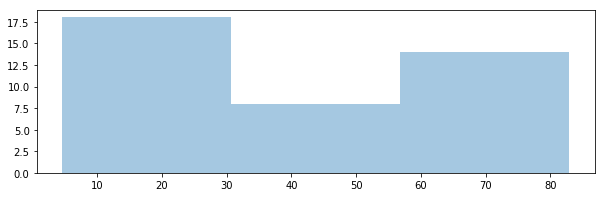

In [46]:
plt.rcParams['figure.figsize'] = (10, 3)
_ = sns.distplot(fns_amps, kde=False)

/home/Edu/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


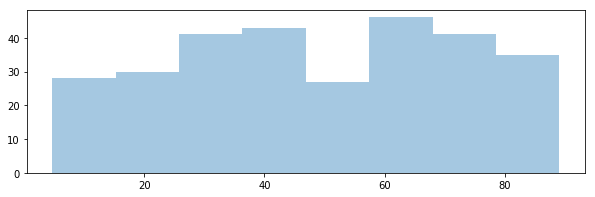

In [47]:
plt.rcParams['figure.figsize'] = (10, 3)
_ = sns.distplot(fps_amps, kde=False)

# Running detection step

In [48]:
from copy import copy

yass.set_config("../config/49-lab.yaml")
CONFIG = read_config()

cfg = copy(CONFIG._data)

cfg['detect']['neural_network_detector']['filename'] = detect_name
cfg['detect']['neural_network_triage']['filename'] = triage_name

output_dir = 'tmp'

cfg.pop('channel_groups')
cfg.pop('channel_index')
cfg.pop('geom')
cfg.pop('neigh_channels')
cfg.pop('spike_size')

yass.set_config(cfg)

DEBUG:yass.config.config:Loaded from file: ../config/49-lab.yaml
DEBUG:yass:CONFIG set to: {'data': {'root_folder': '/home/Edu/data', 'recordings': 'ej49_data1_set1.bin', 'geometry': 'ej49_geometry1.txt'}, 'resources': {'max_memory': '500MB', 'max_memory_gpu': '1MB', 'processes': 'max'}, 'recordings': {'dtype': 'int16', 'sampling_rate': 20000, 'n_channels': 49, 'spatial_radius': 70, 'spike_size_ms': 1, 'order': 'samples'}, 'preprocess': {'apply_filter': True, 'dtype': 'float32', 'if_file_exists': 'skip', 'filter': {'order': 3, 'low_pass_freq': 300, 'high_factor': 0.1}}, 'detect': {'method': 'nn', 'temporal_features': 3, 'save_results': False, 'if_file_exists': 'skip', 'neural_network_detector': {'filename': '/home/Edu/dev/yass/src/yass/assets/models/detect_nn1.ckpt', 'threshold_spike': 0.5}, 'neural_network_triage': {'filename': '/home/Edu/dev/yass/src/yass/assets/models/triage_nn1.ckpt', 'threshold_collision': 0.5}, 'neural_network_autoencoder': {'filename': '/home/Edu/dev/yass/src/ya

In [49]:
CONFIG = read_config()

print(CONFIG['detect']['neural_network_detector']['filename'])
print(CONFIG['detect']['neural_network_triage']['filename'])

/home/Edu/dev/private-yass/nnet/models/detect-04-Jul-2018@15-56-13.ckpt
/home/Edu/dev/private-yass/nnet/models/triage-04-Jul-2018@15-56-47.ckpt


In [50]:
(path_to_standarized,
 standarized_params,
 whiten_filter) = preprocess.run(output_directory=output_dir,
                                 if_file_exists='skip')

INFO:yass.preprocess.run:Output dtype for transformed data will be float32


In [52]:
_, spikes_clear, spikes_all  = detect.run(path_to_standarized, standarized_params, whiten_filter)

DEBUG:yass.util:Parameter path is not a string or a Path object, function will just return the parameter, type: <class 'dict'>
DEBUG:yass.util:Parameter path is not a string or a Path object, function will just return the parameter, type: <class 'numpy.ndarray'>
DEBUG:yass.batch.generator:Max memory: 1 MB. Itemsize: 4 bytes
/home/Edu/dev/yass/src/yass/neuralnetwork/model_triage.py:73: UserWarning: Network n_neighbors (7) does not match n_neighbors on input_tensor (19), using only the first n_neighbors from the input_tensor
  input_tensor.shape[2]))
DEBUG:yass.neuralnetwork.model_detector:Restoring tensorflow session from: /home/Edu/dev/private-yass/nnet/models/detect-04-Jul-2018@15-56-13.ckpt
DEBUG:yass.neuralnetwork.model_triage:Restoring tensorflow session from: /home/Edu/dev/private-yass/nnet/models/triage-04-Jul-2018@15-56-47.ckpt
INFO:yass.batch.batch:Applying function yass.neuralnetwork.apply.run_detect_triage_featurize...

  0%|          | 0/1122 [00:00<?, ?it/s]DEBUG:yass.batch

InvalidArgumentError: Input to reshape is a tensor with 958797 values, but the requested shape requires a multiple of 31
	 [[Node: Reshape_6 = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _device="/job:localhost/replica:0/task:0/device:GPU:0"](transpose_14, Reshape_6/shape)]]
	 [[Node: transpose_15/_63 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_282_transpose_15", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'Reshape_6', defined at:
  File "/home/Edu/miniconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/Edu/miniconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/Edu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/Edu/miniconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/Edu/miniconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/Edu/miniconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/home/Edu/miniconda3/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/home/Edu/miniconda3/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/home/Edu/miniconda3/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/Edu/miniconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/home/Edu/miniconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/Edu/miniconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/Edu/miniconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/Edu/miniconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/Edu/miniconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/Edu/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/Edu/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/Edu/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/Edu/miniconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/Edu/miniconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/Edu/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/Edu/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/Edu/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/Edu/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-52-fcfea5fd13ad>", line 1, in <module>
    _, spikes_clear, spikes_all  = detect.run(path_to_standarized, standarized_params, whiten_filter)
  File "/home/Edu/dev/yass/src/yass/detect/run.py", line 112, in run
    save_results)
  File "/home/Edu/dev/yass/src/yass/detect/run.py", line 283, in run_neural_network
    NNAE = AutoEncoder(ae_fname, input_tensor=NND.waveform_tf)
  File "/home/Edu/dev/yass/src/yass/neuralnetwork/model_autoencoder.py", line 59, in __init__
    self.score_tf = self._make_graph(input_tensor)
  File "/home/Edu/dev/yass/src/yass/neuralnetwork/model_autoencoder.py", line 86, in _make_graph
    [-1, n_input])
  File "/home/Edu/miniconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 6113, in reshape
    "Reshape", tensor=tensor, shape=shape, name=name)
  File "/home/Edu/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/Edu/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/home/Edu/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Input to reshape is a tensor with 958797 values, but the requested shape requires a multiple of 31
	 [[Node: Reshape_6 = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _device="/job:localhost/replica:0/task:0/device:GPU:0"](transpose_14, Reshape_6/shape)]]
	 [[Node: transpose_15/_63 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_282_transpose_15", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [ ]:
print(f'All spikes: {spikes_all.shape[0]:,}\nClear spikes: {spikes_clear.shape[0]:,}')

# Predict

In [ ]:
# output_dir = 'tmp/'

# (path_to_standarized,
#  standarized_params,
#  whiten_filter) = preprocess.run(output_directory=output_dir,
#                                  if_file_exists='skip')

In [ ]:
# explorer_std = RecordingExplorer(path_to_standarized,
#                                  path_to_geom=None,
#                                  spike_size=15, neighbor_radius=70)

In [ ]:
# _data = explorer_std.reader.data
# window_size = 10000
# idx = gt[105963, 0]
# data = _data[idx-window_size:idx+window_size, :]

## Detect predict

In [ ]:
# output_names = ('spike_index', 'waveform', 'probability')

# (spike_index, waveform,
#  proba) = detector.predict(data, output_names=output_names)

In [ ]:
# _ = plt.plot(data)

In [ ]:
# _ = plt.plot(waveform[0, :])

In [ ]:
# _ = plt.plot(proba)

## Triage predict

In [ ]:
# # to_triage = waveform[:, :, :x_triage.shape[2]]
# to_triage = small_templates

In [ ]:
# idx_clean = triage.predict(to_triage)

In [ ]:
# not_clean = np.where(~idx_clean)[0]

In [ ]:
# plt.rcParams['figure.figsize'] = (10, 10)
# plot.grid(small_templates, axis=0, elements=not_clean, sharey=False)